In [1]:
# coding: utf-8

In [15]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
import sklearn as sk
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import OneHotEncoder
import os
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers import Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report
from keras.preprocessing.text import hashing_trick
from keras.preprocessing.text import text_to_word_sequence
from keras.regularizers import l2

from keras.preprocessing.text import Tokenizer
from keras.layers import Conv2D, MaxPooling2D

In [16]:
filenames = ["reviews_Musical_Instruments_5.json"]
filename = "reviews_Musical_Instruments_5.json"
t = Tokenizer()
max_features = 20000
maxlen = 100
batch_size = 32

dictionary_size = 0
embed_dim = 300
num_hidden_unit_lstm = 300
num_filter = 100
window_size = 3
pool_size = 2
batch_size = 10
learning_rate = 0.1
#AdaDelta
dropout_embed = 0.5
dropout_blstm = 0.2
dropout_penultimate = 0.4
l2_lambda = 0.000001

randomShuffle = ShuffleSplit(n_splits=1, test_size=.2, random_state=0)

In [17]:
data = pd.read_json(filename, lines=True, orient="frame")

In [18]:
data.head(10)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,1384719342,"[0, 0]",5,"Not much to write about here, but it does exac...","02 28, 2014",A2IBPI20UZIR0U,"cassandra tu ""Yeah, well, that's just like, u...",good,1393545600
1,1384719342,"[13, 14]",5,The product does exactly as it should and is q...,"03 16, 2013",A14VAT5EAX3D9S,Jake,Jake,1363392000
2,1384719342,"[1, 1]",5,The primary job of this device is to block the...,"08 28, 2013",A195EZSQDW3E21,"Rick Bennette ""Rick Bennette""",It Does The Job Well,1377648000
3,1384719342,"[0, 0]",5,Nice windscreen protects my MXL mic and preven...,"02 14, 2014",A2C00NNG1ZQQG2,"RustyBill ""Sunday Rocker""",GOOD WINDSCREEN FOR THE MONEY,1392336000
4,1384719342,"[0, 0]",5,This pop filter is great. It looks and perform...,"02 21, 2014",A94QU4C90B1AX,SEAN MASLANKA,No more pops when I record my vocals.,1392940800
5,B00004Y2UT,"[0, 0]",5,So good that I bought another one. Love the h...,"12 21, 2012",A2A039TZMZHH9Y,"Bill Lewey ""blewey""",The Best Cable,1356048000
6,B00004Y2UT,"[0, 0]",5,"I have used monster cables for years, and with...","01 19, 2014",A1UPZM995ZAH90,Brian,Monster Standard 100 - 21' Instrument Cable,1390089600
7,B00004Y2UT,"[0, 0]",3,I now use this cable to run from the output of...,"11 16, 2012",AJNFQI3YR6XJ5,"Fender Guy ""Rick""",Didn't fit my 1996 Fender Strat...,1353024000
8,B00004Y2UT,"[0, 0]",5,Perfect for my Epiphone Sheraton II. Monster ...,"07 6, 2008",A3M1PLEYNDEYO8,"G. Thomas ""Tom""",Great cable,1215302400
9,B00004Y2UT,"[0, 0]",5,Monster makes the best cables and a lifetime w...,"01 8, 2014",AMNTZU1YQN1TH,Kurt Robair,Best Instrument Cables On The Market,1389139200


In [19]:
data['overall'] = np.where(data['overall'] < 3, 0, data.overall)
data['overall'] = np.where(data['overall'] == 3, 1, data.overall)
data['overall'] = np.where(data['overall'] > 3, 2, data.overall)

In [20]:
data.head(10)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,1384719342,"[0, 0]",2,"Not much to write about here, but it does exac...","02 28, 2014",A2IBPI20UZIR0U,"cassandra tu ""Yeah, well, that's just like, u...",good,1393545600
1,1384719342,"[13, 14]",2,The product does exactly as it should and is q...,"03 16, 2013",A14VAT5EAX3D9S,Jake,Jake,1363392000
2,1384719342,"[1, 1]",2,The primary job of this device is to block the...,"08 28, 2013",A195EZSQDW3E21,"Rick Bennette ""Rick Bennette""",It Does The Job Well,1377648000
3,1384719342,"[0, 0]",2,Nice windscreen protects my MXL mic and preven...,"02 14, 2014",A2C00NNG1ZQQG2,"RustyBill ""Sunday Rocker""",GOOD WINDSCREEN FOR THE MONEY,1392336000
4,1384719342,"[0, 0]",2,This pop filter is great. It looks and perform...,"02 21, 2014",A94QU4C90B1AX,SEAN MASLANKA,No more pops when I record my vocals.,1392940800
5,B00004Y2UT,"[0, 0]",2,So good that I bought another one. Love the h...,"12 21, 2012",A2A039TZMZHH9Y,"Bill Lewey ""blewey""",The Best Cable,1356048000
6,B00004Y2UT,"[0, 0]",2,"I have used monster cables for years, and with...","01 19, 2014",A1UPZM995ZAH90,Brian,Monster Standard 100 - 21' Instrument Cable,1390089600
7,B00004Y2UT,"[0, 0]",1,I now use this cable to run from the output of...,"11 16, 2012",AJNFQI3YR6XJ5,"Fender Guy ""Rick""",Didn't fit my 1996 Fender Strat...,1353024000
8,B00004Y2UT,"[0, 0]",2,Perfect for my Epiphone Sheraton II. Monster ...,"07 6, 2008",A3M1PLEYNDEYO8,"G. Thomas ""Tom""",Great cable,1215302400
9,B00004Y2UT,"[0, 0]",2,Monster makes the best cables and a lifetime w...,"01 8, 2014",AMNTZU1YQN1TH,Kurt Robair,Best Instrument Cables On The Market,1389139200


0: 467		4.55%
1: 772		7.52%
2: 9022		87.93%


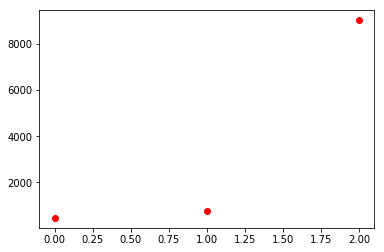

In [21]:
label = list(data.iloc[:, 2].values)
for j in range(3):
    print(str(j) + ": " + str(label.count(j)) + "\t\t" + str(round(label.count(j) / len(label) * 100, 2)) + "%")

plt.plot([0, 1, 2], [label.count(0), label.count(1), label.count(2)], 'ro')
plt.show()

In [45]:
def getEmbeddingMatrix(vocabulary_size):
    embeddings_index = dict()
    f = open('glove.6b/glove.6B.300d.txt', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))
    embedding_matrix = np.zeros((vocabulary_size, embed_dim))
    for word, i in t.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [49]:
def getXY(filename):
    data = pd.read_json(filename, lines=True, orient="frame")
    data['overall'] = np.where(data['overall'] < 3, 0, data.overall)
    data['overall'] = np.where(data['overall'] == 3, 1, data.overall)
    data['overall'] = np.where(data['overall'] > 3, 2, data.overall)
    good_columns = [3]
    num_rating = 3
    onehot_encoder = OneHotEncoder(sparse=False)
    data_X = data.iloc[:, good_columns]
    data_Y = data.iloc[:, 2]
    
    reviewTextList = data.reviewText.values
    t.fit_on_texts(reviewTextList)
    text = t.texts_to_sequences(reviewTextList)
    text = sequence.pad_sequences(text, maxlen=maxlen)
    print('text shape:', text.shape)
    vocabulary_size = len(t.word_index) + 1
    print('vocabulary size:', vocabulary_size)
    
    data_X = np.array(text)
    data_Y = np_utils.to_categorical(data_Y, num_rating)
    return data_X, data_Y, vocabulary_size

In [50]:
def bidirectionalLSTMModel(x_train, x_test, y_train, y_test, batch_size, epochs):
    model = Sequential()
    model.add(Embedding(max_features, 128, input_length=maxlen))
    model.add(Bidirectional(LSTM(num_hidden_unit_lstm)))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='sigmoid'))

    print(model.summary())
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adadelta',
                  metrics=['accuracy'])
    
    print('Train...')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=[x_test, y_test])
    
    score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
    print('Test score:', score)
    print('Test accuracy:', acc)
    y_test = np.argmax(y_test, axis=1)
    y_pred = model.predict_classes(x_test)
    print(classification_report(y_test, y_pred))

In [51]:
def bidirectionalLSTMCNNModel(x_train, x_test, y_train, y_test, batch_size, epochs, vocabulary_size, embedding_matrix):
    print("x_train: ", x_train.shape)
    print("y_train: ", y_train.shape)
    print("x_test: ", x_test.shape)
    print("y_test: ", y_test.shape)
#     print("x_train:",x_train[0])
#     print("x_test:",x_test[0])
#     print('y_train:',y_train[0])
#     print('y_test',y_test[0])
    model = Sequential()
    print("vocabulary_size:", vocabulary_size)
#     model.add(Embedding(input_dim=vocabulary_size, output_dim=embed_dim, input_length=maxlen))
    model.add(Embedding(input_dim=vocabulary_size, output_dim=embed_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False))
    model.add(Dropout(0.5))
    model.add(
        Bidirectional(
            LSTM(
                num_hidden_unit_lstm, 
                return_sequences=True, 
                 kernel_regularizer=l2(l2_lambda)
            ), 
            merge_mode="sum"
        ))
    model.add(Dropout(0.2))
    model.add(Reshape((maxlen, embed_dim, 1)))
    model.add(Conv2D(num_filter,
                     kernel_size=(3,3),
                     padding='valid',
                     activation='relu',
                     strides=1,
                      kernel_regularizer=l2(l2_lambda)
                    ))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(3, kernel_regularizer=l2(l2_lambda)))
    model.add(Activation('sigmoid'))

    print(model.summary())
    model.compile(loss='categorical_crossentropy', 
                  optimizer='Adadelta',
                  metrics=['accuracy'])
    
    print('Train...')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=[x_test, y_test])
    
    score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
    print('Test score:', score)
    print('Test accuracy:', acc)
    y_test = np.argmax(y_test, axis=1)
    y_pred = model.predict_classes(x_test)
    print(classification_report(y_test, y_pred))

In [27]:
vocabulary_size = 0
filename = filenames[0]
X, Y, vocabulary_size = getXY(filename)
embedding_matrix = getEmbeddingMatrix(vocabulary_size)

text shape: (10261, 100)
vocabulary size: 21623
Loaded 400000 word vectors.


In [ ]:
vocabulary_size = 0
for filename in filenames:
    print("-----------------------------")
    print(filename + ":")
    X, Y, vocabulary_size = getXY(filename)
    embedding_matrix = getEmbeddingMatrix(vocabulary_size)
    for train_index, test_index in randomShuffle.split(X):
        X_train = X[train_index]
        Y_train = Y[train_index, :]
        X_test = X[test_index]
        Y_test = Y[test_index, :]
        
        bidirectionalLSTMCNNModel(X_train, X_test, Y_train, Y_test, 10, 30, vocabulary_size, embedding_matrix)

-----------------------------
reviews_Musical_Instruments_5.json:
text shape: (10261, 100)
vocabulary size: 21623
Loaded 400000 word vectors.
x_train:  (8208, 100)
y_train:  (8208, 3)
x_test:  (2053, 100)
y_test:  (2053, 3)
vocabulary_size: 21623
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 300)          6486900   
_________________________________________________________________
dropout_11 (Dropout)         (None, 100, 300)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 300)          1442400   
_________________________________________________________________
dropout_12 (Dropout)         (None, 100, 300)          0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 100, 300, 1)       0         
___________________________

In [22]:
def createCNNLSTMModel(x_train, x_test, y_train, y_test, batch_size, epochs):
    # Embedding
    max_features = 20000
    maxlen = 100
    embedding_size = 128

    # Convolution
    kernel_size = 5
    filters = 64
    pool_size = 4

    # LSTM
    lstm_output_size = 70

    print('Build model...')

    model = Sequential()
    model.add(Embedding(max_features, embedding_size, input_length=maxlen))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters,
                     kernel_size=[window_size, window_size],
                     #padding='valid',
                     #activation='relu',
                     #strides=1
                    ))
    model.add(MaxPooling2D(pool_size=(pooling_size, pooling_size))
    model.add(Dense(3))
    model.add(Activation('sigmoid'))

    print(model.summary())
    model.compile(loss='categorical_crossentropy',
                  optimizer='AdaDelta',
                  metrics=['accuracy'])

    print('Train...')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test))

    score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
    print('Test score:', score)
    print('Test accuracy:', acc)
    y_test = np.argmax(y_test, axis=1)
    y_pred = model.predict_classes(x_test)
    print(classification_report(y_test, y_pred))

SyntaxError: invalid syntax (<ipython-input-22-eebad838108f>, line 27)

In [23]:
for filename in filenames:
    print("-----------------------------")
    print(filename + ":")
    X, Y = getXY(filename)
    for train_index, test_index in randomShuffle.split(X):
        X_train = X[train_index]
        Y_train = Y[train_index, :]
        X_test = X[test_index]
        Y_test = Y[test_index, :]
        
        createCNNLSTMModel(X_train, X_test, Y_train, Y_test, 32, 10)

-----------------------------
reviews_Musical_Instruments_5.json:
text shape: (10261, 100)


NameError: name 'createCNNLSTMModel' is not defined